In [186]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

class CSensor(object):
    def __init__(self,name,x = 0, y = 0):
        self.name = name
        self.x_base = x
        self.y_base = y
        self.heading =math.pi - math.atan2(self.x_base,self.y_base)        
    def set_price(self,price = 1):
        self.price = price
    def __str__(self,print_all = False):
        if print_all :
            return " ".join(str(items) for items in (self.__dict__.items()))
        else:
            return self.name

## Define the Mat class

In [187]:
class CMate(CSensor):
    def __init__(self,name,x = 0, y = 0,width = 1,length = 1):
        super(CMate,self).__init__(name,x,y)
        self.width = width
        self.length = length
        self._calc_contour()
    def _calc_contour(self):
        self.mate_x = []
        self.mate_y = []
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(self.width/2)
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(-self.width/2)
        
        self.mate_x.append(-self.length/2)
        self.mate_y.append(-self.width/2)
        
        self.mate_x.append(-self.length/2)
        self.mate_y.append(self.width/2)
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(self.width/2)
        
        self.__mate_x,self.__mate_y = self._interpolate(self.mate_x,self.mate_y)
    
    def _interpolate(self,x,y):
        rx,ry = [],[]
        dtheta = 0.05
        for i in range(len(x) - 1):
            rx.extend([(1.0 - θ) * x[i] + θ * x[i + 1] # interpolate the edges
                       for θ in np.arange(0.0, 1.0, dtheta)])
            ry.extend([(1.0 - θ) * y[i] + θ * y[i + 1]
                       for θ in np.arange(0.0, 1.0, dtheta)])            
        return rx, ry
    
    def calc_global_contour(self):
        gx = [(ix * np.cos(self.heading) + iy * np.sin(self.heading)) +
              self.x_base for (ix, iy) in zip(self.__mate_x, self.__mate_y)]
        gy = [(ix * np.sin(self.heading) - iy * np.cos(self.heading)) +
              self.y_base for (ix, iy) in zip(self.__mate_x, self.__mate_y)]
        return gx, gy
    
    def detect_human(self,human):
        self.corner_x = [(ix * np.cos(self.heading) + iy * np.sin(self.heading)) +
              self.x_base for (ix, iy) in zip(self.mate_x[0:4], self.mate_y[0:4])]
        self.corner_y = [(ix * np.sin(self.heading) - iy * np.cos(self.heading)) +
              self.y_base for (ix, iy) in zip(self.mate_x[0:4], self.mate_y[0:4])]
        gx,gy = human.standing_area()
        x,y = [],[]
        for vx,vy in zip(gx,gy):
            if(self.check(vx,vy)):
                x.append(vx)
                y.append(vy)
        return x,y
    
    def area(self,x1, y1, x2, y2, x3, y3): 
      
        return abs((x1 * (y2 - y3) + 
                x2 * (y3 - y1) + 
                x3 * (y1 - y2)) / 2.0) 
    
    def check(self,x, y):
        x1 = self.corner_x[0]
        x2 = self.corner_x[1]
        x3 = self.corner_x[2]
        x4 = self.corner_x[3]
        y1 = self.corner_y[0]
        y2 = self.corner_y[1]
        y3 = self.corner_y[2]
        y4 = self.corner_y[3]
        A = (self.area(x1, y1, x2, y2, x3, y3) + self.area(x1, y1, x4, y4, x3, y3))  
        A1 = self.area(x, y, x1, y1, x2, y2) 
        A2 = self.area(x, y, x2, y2, x3, y3) 
        A3 = self.area(x, y, x3, y3, x4, y4)  
        A4 = self.area(x, y, x1, y1, x4, y4) 
        return (np.abs(A1 + A2 + A3 + A4 - A)<0.01) 
    
    def plot(self,fig):
        fig.plot(self.x_base,self.y_base,".b")
        gx,gy = self.calc_global_contour()
        plt.plot(gx,gy,"--b")
        plt.text(self.x_base,self.y_base,self.name)
        
class CMatePlotter:
    def __init__(self, x, y,  colorcode = 'r'):
        self.x = x
        self.y = y
        self.color = colorcode
        
    def plot_scan(self, plt, ox, oy):
        x = [ox[i] for i in range(len(ox))]
        y = [oy[i] for i in range(len(ox))]

        for (ix, iy) in zip(x, y):
            plt.plot([self.x, ix], [self.y, iy], self.color)

## Define the Fence class

In [188]:
class CFence(CSensor): # Fence only influences the movement direction of human
    def __init__(self,name,x = 0, y = 0,width = 1,length = 1):
        super(CFence,self).__init__(name,x,y)
        self.width = width
        self.length = length
        self._calc_contour()
    def _calc_contour(self):
        self.mate_x = []
        self.mate_y = []
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(self.width/2)
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(-self.width/2)
        
        self.mate_x.append(-self.length/2)
        self.mate_y.append(-self.width/2)
        
        self.mate_x.append(-self.length/2)
        self.mate_y.append(self.width/2)
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(self.width/2)
        
        self.__mate_x,self.__mate_y = self._interpolate(self.mate_x,self.mate_y)
    
    def _interpolate(self,x,y):
        rx,ry = [],[]
        dtheta = 0.05
        for i in range(len(x) - 1):
            rx.extend([(1.0 - θ) * x[i] + θ * x[i + 1] # interpolate the edges
                       for θ in np.arange(0.0, 1.0, dtheta)])
            ry.extend([(1.0 - θ) * y[i] + θ * y[i + 1]
                       for θ in np.arange(0.0, 1.0, dtheta)])            
        return rx, ry
    
    def calc_global_contour(self):
        gx = [(ix * np.cos(self.heading) + iy * np.sin(self.heading)) +
              self.x_base for (ix, iy) in zip(self.__mate_x, self.__mate_y)]
        gy = [(ix * np.sin(self.heading) - iy * np.cos(self.heading)) +
              self.y_base for (ix, iy) in zip(self.__mate_x, self.__mate_y)]
        return gx, gy
        
    def plot(self,fig):
        fig.plot(self.x_base,self.y_base,".y")
        gx,gy = self.calc_global_contour()
        plt.plot(gx,gy,"--y")
        plt.text(self.x_base,self.y_base,self.name)




## Define the human class

In [189]:
class CHuman(object):
    # represent the human with a circle, which stands for the arm operation, with radius r=1
    def __init__(self,name,start_vel = 0.1, start_pos_x = - 4.5,start_pos_y = -3,heading = 0):
        self.x = start_pos_x
        self.y = start_pos_y
        self.vel = start_vel
        self.name = name
        self.arm = 1
        if heading == 0:
            self.heading =  np.pi + math.atan2(self.x,self.y)
        else:
            self.heading = heading
    def standing_area(self):

        segment = 10
        seg_x = [self.arm * math.cos(theta) for theta in np.arange(0,np.pi*2,2*np.pi/segment)]
        seg_y = [self.arm * math.sin(theta) for theta in np.arange(0,np.pi*2,2*np.pi/segment)]
        
        gx = np.asarray(seg_x) * math.cos(self.heading)  + np.asarray(seg_y) * math.sin(self.heading) + self.x
        gy = -np.asarray(seg_x) * math.sin(self.heading) + np.asarray(seg_y) * math.cos(self.heading) + self.y
        return gx,gy
    
    # Use dynamic model to update the position of the human
    def update(self,dt, omega = 0.1, a = 0, max_vel = 2):
        self.x += self.vel * np.cos(self.heading) * dt
        self.y += self.vel * np.sin(self.heading) * dt
        self.heading += omega * dt
        self.vel += a * dt
        # at first step, always assume to be the constant vel and linear dynamics
        if self.vel > max_vel:
            self.vel = max_vel        
         
    def plot(self,fig):
        #fig.plot(self.x,self.y,"sg")
        plt.text(self.x,self.y,self.name)
        gx,gy = self.standing_area()
        fig.plot(gx,gy,"sr")
        human_circle = plt.Circle((self.x,self.y),self.arm,color = 'lime', fill = True)
        fig.add_artist(human_circle)

## Define the Robot class

In [190]:
class CRobot(object):
    def __init__(self,name,start_vel = 1, start_pos = 0):
        self.name = name
        self.x_base = 0
        self.y_base = 0
        self.vel = start_vel
        self.pos = start_pos - math.pi/2
        self.range = 2.5
        self.__baseRadius = 0.5
        self.eef_x = self.range * math.sin(self.pos)
        self.eef_y = self.range * math.cos(self.pos)
        
    def update(self):
        self.pos -= self.vel
        self.eef_x = self.range * math.sin(self.pos)
        self.eef_y = self.range * math.cos(self.pos)
    def plot(self,fig):
        #fig.plot(self.x_base,self.y_base,"sr")
        fig.plot(self.eef_x,self.eef_y,"sr")
        base = plt.Circle((self.x_base,self.y_base),self.__baseRadius,color = 'r', fill = True)
        fig.add_artist(base)
        fig.plot([self.x_base,self.eef_x],[self.y_base,self.eef_y],"-r")
        plt.text(self.x_base-1,self.y_base+0.1,self.name)

## Define the Lidar Class

In [191]:
class CLidar(CSensor):
    # Adding the Lidar frame update frequence as wa parameter 
    def __init__(self,name,x = 0, y = 0,lidar_range = 7,angle_res = 0.01,min_angle = -math.pi/2, max_angle = math.pi/2):
        super(CLidar,self).__init__(name,x,y)
        self.Lrange = lidar_range
        self.angle_res = angle_res
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.range_noise = 0.01
        self.heading = math.pi/2 + math.atan2(self.x_base,self.y_base)  
     #TODO:Check whether a point is inside of a rectangle：
    # A Chinese Blog :https://blog.csdn.net/qq_34342154/article/details/78257827
    def object_detection(self,human):
    # Note: In the first version, Lidar only detects the human
        x,y,angle,r = [],[],[],[]
        gx,gy = human.standing_area()
        for vx,vy in zip(gx,gy):
            vx = vx - self.x_base
            vy = vy - self.y_base
            vangle = math.atan2(vy,vx)
            vr = np.hypot(vx,vy)
            # Should we use Gaussian to simulate the noise?
            # vr = np.hypot(vx,vy) + * random.uniform(1.0 -self.range_noise, 1.0 + self.range_noise)
            x.append(vx)
            y.append(vy)
            angle.append(vangle)
            r.append(vr)
        distance = np.hypot(np.hypot(self.x_base - human.x, self.y_base - human.y),human.arm)
        rx,ry = self.ray_casting_filter(x,y,angle,r,distance)
        rx = [ x + self.x_base for x in rx]
        ry = [ y + self.y_base for y in ry]
        
        return rx,ry
    def unit_vector(self,vector):
        return vector / np.linalg.norm(vector)

    def angle_between(self,v1, v2):
        v1_u = self.unit_vector(v1)
        v2_u = self.unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
        
    
    def ray_casting_filter(self,xl,yl,thetal,rangel,distance):
        rx,ry = [],[]
        rangedb = [float("inf") for _ in range(
            int(np.floor((np.pi * 2.0) / self.angle_res)) + 1)]
        # init the lidar results with "inf"

        for i in range(len(thetal)):
            angleid = int(round(thetal[i] / self.angle_res))
            
            vector_1 = (xl[i],yl[i])
            vector_2 = (-self.x_base,-self.y_base)
            angle_in_range = np.abs(self.angle_between(vector_1,vector_2)) < self.max_angle

            if (rangedb[angleid] > rangel[i] and rangel[i] < self.Lrange and rangel[i]<distance and angle_in_range):
                rangedb[angleid] = rangel[i]

        for i in range(len(rangedb)):
            t = i * self.angle_res
            if rangedb[i] != float("inf"):
                rx.append(rangedb[i] * np.cos(t))
                ry.append(rangedb[i] * np.sin(t))
        return rx, ry

    #def object_detection(self):
     #   v1 = (lidar.x_base-robot.x_base,lidar.y_base-robot.y_base)
      #  v2 = (lidar.x_base - human.x,lidar.y_base - human.y)
       # angle_between(v1,v2) < lidar.max_angle

    def plot(self,fig):
        fig.plot(self.x_base,self.y_base,"^g")
        plt.text(self.x_base,self.y_base,self.name)

class CLidarPlotter:
    def __init__(self, x, y,  colorcode = 'r'):
        self.x = x
        self.y = y
        self.color = colorcode
        
    def plot_scan(self, plt, ox, oy):
        x = [ox[i] for i in range(len(ox))]
        y = [oy[i] for i in range(len(ox))]

        for (ix, iy) in zip(x, y):
            plt.plot([self.x, ix], [self.y, iy], self.color)

In [192]:
def draw_warn_zone(fig,robot,wz = 3):
    
    dz = plt.Circle((robot.x_base,robot.y_base),robot.range,color = 'red', fill = False)
    fig.add_artist(dz)
    wz = plt.Circle((robot.x_base,robot.y_base),wz,color = 'orange', fill = False)
    fig.add_artist(wz)

In [197]:
mate = CMate('Mate1',x = 6, y = 4,width=4,length=6)
fence = CFence('Fence1', x = -2, y=-6, width = 0.5,length = 4)
lidar = CLidar('Lidar1',x=2,y=2)
robot = CRobot('Robot1',start_vel = 0.1,start_pos =0)
human = CHuman('Worker1',start_vel = 1, start_pos_x = -2.5,start_pos_y = -3,heading = 0)
lidar_plt = CLidarPlotter(x=lidar.x_base,y=lidar.y_base,colorcode='g')
mate_plt = CMatePlotter(x=mate.x_base,y=mate.y_base,colorcode='y')

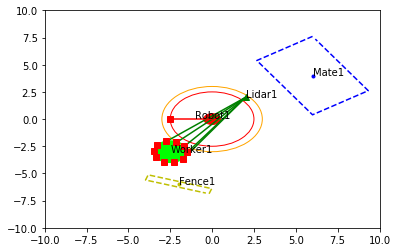

In [198]:
fig,axes = plt.subplots(1,1)
rx,ry = lidar.object_detection(human)
mx,my = mate.detect_human(human)
axes.cla()
#axes.axis("equal")
axes = plt.gca()
axes.set_xlim([-10,10])
axes.set_ylim([-10,10])
mate.plot(axes)
fence.plot(axes)
lidar.plot(axes)
lidar_plt.plot_scan(axes, rx, ry)
mate_plt.plot_scan(axes,mx,my)
human.plot(axes)
robot.plot(axes)
draw_warn_zone(axes,robot)

In [199]:
current_time = 0
dt = 2 # time step

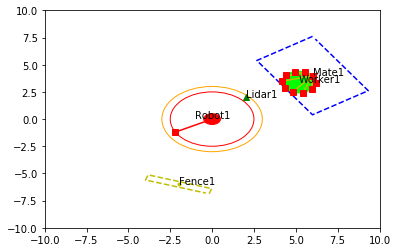

In [200]:
fig,axes = plt.subplots(1,1)
while current_time < simulation_time:
    human.update(dt,omega = 0)
    robot.update()
    current_time += dt
mx,my = mate.detect_human(human)
rx,ry = lidar.object_detection(human)    
axes.cla()
#axes.axis("equal")
axes = plt.gca()
axes.set_xlim([-10,10])
axes.set_ylim([-10,10])
mate.plot(axes)
fence.plot(axes)
lidar.plot(axes)
lidar_plt.plot_scan(axes, rx, ry)
mate_plt.plot_scan(axes,mx,my)
human.plot(axes)
robot.plot(axes)
draw_warn_zone(axes,robot)

## Question
- about the heading problem, always heading the robot? Up to now, yes.
- Since we also simulate the human dynamic, how define it?

## TODO
- adding framerate and detection angle to the Laser
- adding the human dynamic properties
- mate detect the human: use the algorithms Point in Rectangle